# Self study 1

In this self study you should work on the code examples below together with the associated questions. The notebook illustrates a basic neural network implementation, where we implement most of the relevant functions from scratch, except for the calculation of the gradients, for which we rely on the functionality provided by <a urel="https://pytorch.org">PyTorch</a>. 

Since we rely on PyTorch functionality, we will also be using PyTorch's tensor data structure. This data structure operates in much the same way as numpy's ndarrays. You can find a brief introduction to PyTorch's tensors <a href="https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html">here</a>.  



The code illustrates the key concepts involved in the learning neural network. Go carefully through the code before starting to answer the questions at the end.

First we import the modules used in this selfstudy

In [74]:
import torch
from torchvision import datasets, transforms
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np

Through torch load the MNIST data set, which we will use in this self study. The MNIST database consists of grey scale images of handwritten digits. Each image is of size $28\times 28$; see figure below for an illustration. The data set is divided into a training set consisting of $60000$ images and a test set with $10000$ images; in both
data sets the images are labeled with the correct digits. If interested, you can find more information about the MNIST data set at http://yann.lecun.com/exdb/mnist/, including accuracy results for various machine learning methods.

![MNIST DATA](MNIST-dataset.png)

Using the data loader provided by torch we have an easy way of loading in data in batches (here of size 64). We can also make various other transformation of the data, such as normalization. The details for loading the data are not really that important, but if yiu are curious, you can find a quick introduction <a href="https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html">here</a>.

In [75]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=batch_size, shuffle=True)

In the cell above, we are loading data in batches, which is subsequently used during optimization. We didn't discuss batch based learning during the last lecture, but please take a look at Slides 24 and 25 to get the gist of the approach. We will cover it in more detail during the next lecture.   

Each batch is a list of two elements. The first element encodes the digit and has dimensions [64,1,28,28] (the figures are greyscale with no rbg channel, hence the '1'), and the second element contains the class/label information. 

Batch dimension (digit): torch.Size([128, 1, 28, 28])
Batch dimension (target): torch.Size([128])
Target: 3 with shape torch.Size([])


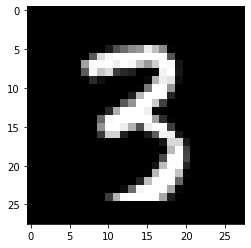

In [76]:
batch = iter(train_loader).next()
print(f"Batch dimension (digit): {batch[0].shape}")
print(f"Batch dimension (target): {batch[1].shape}")
digit_batch = batch[0]
img = digit_batch[0,:]
pyplot.imshow(img.reshape((28, 28)), cmap="gray")
print(f"Target: {batch[1][0]} with shape {batch[1][0].shape}")

With PyTorch we can specify that the tensors require gradients. This will make PyTorch record all operations performed on the tensors, so that we can afterwards calculate the gradients automatically using back propagation. See also the code example from the last lecture.

For the first part of this self study we will specify a neural network, which will encode a softmax function (see, e.g., Page 180 in <a href="https://www.deeplearningbook.org/contents/mlp.html">The Deep Learning book</a>). For this we need a (randomly initialized) weight matrix and a bias, and for both of them we need their gradients wrt. our error function (yet to be defined) in order to perform learning. Note that to facilitate matrix multiplication we will flatten our image from $28\times 28$ to $784$. 

In [77]:
# weights = torch.zeros(784, 10) / np.sqrt(784)
# weights = torch.ones(784, 10) / np.sqrt(784)
weights = torch.randn(784, 10) / np.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)
# bias = torch.ones(10, requires_grad=True)
# bias = torch.randn(10, requires_grad=True)

Out model specification

In [78]:
def softmax(x):
    return x.exp() / x.exp().sum(-1).unsqueeze(-1)

def model(xb):
    return softmax(xb @ weights + bias)

Let's test our model (with our randomly initialized weights)

In [79]:
# We flatten the digit representation so that it is consistent with the weight matrix
xb = digit_batch.flatten(start_dim=1)
print(f"Batch shape: {xb.shape}")
preds = model(xb)
print(f"Prediction on first image {preds[0]}")
print(f"Corresponding classification: {preds[0].argmax()}")

Batch shape: torch.Size([128, 784])
Prediction on first image tensor([0.0549, 0.1680, 0.0368, 0.0546, 0.0120, 0.0459, 0.0275, 0.2063, 0.3480,
        0.0459], grad_fn=<SelectBackward0>)
Corresponding classification: 8


Next we define our loss function, in this case the log-loss (or negative log-likelihood):

In [80]:
def nll(input, target):
    return (-input[range(target.shape[0]), target].log()).mean() 
loss_func = nll

# Make a test calculation
yb = batch[1]
print(loss_func(preds,yb))

tensor(2.5597, grad_fn=<MeanBackward0>)


In the end, we are interested in the accuracy of our model

In [81]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [82]:
print(f"Accuracy of model on batch (with random weights): {accuracy(preds, yb)}")

Accuracy of model on batch (with random weights): 0.1171875


Now we are ready to combine it all and perform learning

In [83]:
epochs = 1  # how many epochs to train for
lr = 0.005  # learning rate

train_losses = []
for epoch in range(epochs):

    for batch_idx, (xb, yb) in enumerate(train_loader):

        xb = xb.squeeze().flatten(start_dim=1)
        pred = model(xb)
        Momentum = True
        v = torch.zeros(weights.shape)
        # We specify the loss
        loss = loss_func(pred, yb)
        # and perform backpropagation    
        loss.backward()
        # Lastly we update the weights and bias (torch.no_grad() ensures that no gradient 
        # calculations are taking place in this part of the code)
        with torch.no_grad():
            if Momentum:
                mu = 0.9
                v = mu * v - lr * weights.grad
                weights += v
            else:
                weights -= weights.grad * lr
            bias -= bias.grad * lr
            
            # After updating we set the gradients to zero so that we ar eready for the next round
            weights.grad.zero_()
            bias.grad.zero_()
                    
            if batch_idx % 50 == 0:
                with torch.no_grad():
                    train_loss = np.mean([loss_func(model(txb.squeeze().flatten(start_dim=1)), tyb).item() for txb, tyb in train_loader])
                    print(f"Epoch: {epoch}, B-idx: {batch_idx}, Training loss: {train_loss}")
                    train_losses.append(train_loss)

Epoch: 0, B-idx: 0, Training loss: 2.5748256376303083
Epoch: 0, B-idx: 50, Training loss: 1.1313134894442203
Epoch: 0, B-idx: 100, Training loss: 0.8285673403028232
Epoch: 0, B-idx: 150, Training loss: 0.6984130316960023
Epoch: 0, B-idx: 200, Training loss: 0.6253291418049127
Epoch: 0, B-idx: 250, Training loss: 0.5761918047470833
Epoch: 0, B-idx: 300, Training loss: 0.5424223598767953
Epoch: 0, B-idx: 350, Training loss: 0.5159875018510229
Epoch: 0, B-idx: 400, Training loss: 0.49547370416777475
Epoch: 0, B-idx: 450, Training loss: 0.4787510371665711


Plot the evolution of the training loss

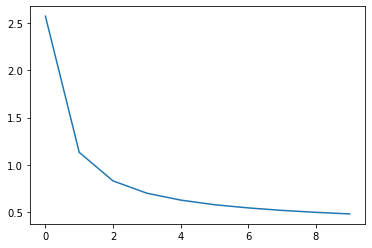

In [84]:
plt.plot(range(len(train_losses)), train_losses)


__Exercise:__ 
1. Experiment with different variations of the gradient descent implementation; try varying the learning rate and the batch size. Assuming that you have a fixed time budget (say 2 minutes for learning), what can we then say about the effect of changing the parameters?
2. Implement momentum in the learning algorithm. How does it affect the results?
3. Try with different initialization schemes for the parameters (e.g. allowing for larger values). How does it affect the behavior of the algorithm?
4. Analyze the behavior of the algorithm on the test set and implement a method for evaluating the accuracy over the entire training/test set.
5. If you feel adventorous, you are welcome to try to specify and experiment with other more advanced model architectures (cell 23). 

Ex 1:
The initial settings for the algorithm is as follows:
- Batch size: 64
- learning rate: 0.01
- Epochs: 1
- training time: 5 minutes
- final loss: 0.35197177977323024

When chancing the batch size to 32 the changes are:
- Batch size: 32
- training time: 10 minutes 17 seconds
- final loss: 0.32472430435617766
When lowering the Batch size to half the training time more than doublets and the loss becomes slightly better.

When changing the batch size to 128 the changes are:
- Batch size: 128
- training time: 2 minutes 30 seconds
- final loss: 0.3095319336538376
Larger batch sizes results in a much better loss and nearly half the training time of the original settings.

Continuing with the larger batch size, because it provided the best results we can now try to change the learning rate.
 - doubling the learning rate results to 0.02.
- final loss: 0.2989273354379353
training time 2 minutes 50 seconds

Halving the learning rate to 0.005
results in:
- final loss: 0.2956689561226729
- training time: 2:50 seconds

Ex 2:
When adding momentum to the best of the model while changing nothing else.
This configuration results in a 10 seconds longer training time at 3 minutes and the best loss yet:
- final loss: 0.2934094262656881

Ex 3:
Continuing with momentum as that has the best results as of yet.
The first modification made will be to change the initialization of the weights in the network. 
Initials these were randomly initialized, but we will try to initialized them all as ones and then as zeros and se what effect it will have on the network.
Initializing the weights to all be 1 results in a much worse loss:
- final loss: 0.47361575260853717

Initializing the weights to all be 0 results in a much worse loss:
- final loss: 0.4583927903221106
Both of these options seem worse than random initialization.

Now to to give the bias the same treatment, initially this is set to be all zero, so the random and ones will be tested.
Initializing the bias to all be 1.
- final loss: 0.5099158100863256
- training time: 3:00

Initializing the bias to all be random.
- final loss: 2:53
- training time: 0.4769889817181935

I suspect some of the results are worse because the my learning rate is too low. And the algorithm is not converging fast enough.


Ex 4:
To evaluate the model on the test set, we will use the losses on the test set, and take the mean loss on the finished model.

In [85]:
# Evaluate the model on the test loader
def evaluate(model, test_loader):
    test_losses = []
    for txb, tyb in test_loader:
        txb = txb.squeeze().flatten(start_dim=1)
        test_losses.append(loss_func(model(txb), tyb).item())
    return np.mean(test_losses)

print(evaluate(model, test_loader))

0.448791315661201
